In [1]:
import os
import json
import yaml
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from recsys.models import FM
from recsys.data.movielens import MovielensDataset
from recsys.utils.metrics import evaluate
from recsys.utils import recommender, visualizer

In [2]:
with open("../configs/config.yaml", "r") as f:
    config = yaml.safe_load(f)
    
with open(config["data"]["experiment_group"], "r") as f:
    experiment_group = json.load(f)
experiment_group[FM.model_name] = []
    
with open(config["data"]["num_sparse_features"], "r") as f:
    num_sparse_features = json.load(f)
    
with open(config["data"]["dense_features"], "r") as f:
    dense_features = json.load(f)

train = pd.read_parquet(config["data"]["train"])
test = pd.read_parquet(config["data"]["test"])

In [3]:
# Define Dataset
train_ds = MovielensDataset(train, list(num_sparse_features.keys()), dense_features)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=config["training"]["batch_size"], shuffle=True)

test_ds = MovielensDataset(test, list(num_sparse_features.keys()), dense_features)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=test["item_id"].nunique(), shuffle=False)

device = torch.device(config["training"]["device"])
model = FM(num_sparse_features=num_sparse_features, dense_features=dense_features, **config["models"][FM.model_name])
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config["training"]["lr"])
print(model)

FactorizationMachine(
  (linear_sparse): ModuleDict(
    (user_id): Embedding(943, 1)
    (item_id): Embedding(1682, 1)
    (gender): Embedding(2, 1)
    (occupation): Embedding(21, 1)
    (genre): Embedding(19, 1)
  )
  (linear_dense): Linear(in_features=1, out_features=1, bias=True)
  (sparse_arch): ModuleDict(
    (user_id): Embedding(943, 16)
    (item_id): Embedding(1682, 16)
    (gender): Embedding(2, 16)
    (occupation): Embedding(21, 16)
    (genre): Embedding(19, 16)
  )
  (dense_arch): Linear(in_features=1, out_features=16, bias=True)
)


Epoch 1/10: 100%|█| 5747/5747 [00:55<00:00, 103.25it/s, auc=0.0000, logloss=1.64
Epoch 2/10: 100%|█| 5747/5747 [00:49<00:00, 115.69it/s, auc=0.5501, logloss=0.29
Epoch 3/10: 100%|█| 5747/5747 [00:49<00:00, 116.30it/s, auc=0.6474, logloss=0.60
Epoch 4/10: 100%|█| 5747/5747 [00:49<00:00, 115.35it/s, auc=0.7282, logloss=0.16
Epoch 5/10: 100%|█| 5747/5747 [00:46<00:00, 122.56it/s, auc=0.7829, logloss=0.35
Epoch 6/10: 100%|█| 5747/5747 [00:47<00:00, 121.98it/s, auc=0.8174, logloss=0.21
Epoch 7/10: 100%|█| 5747/5747 [00:47<00:00, 121.37it/s, auc=0.8440, logloss=0.26
Epoch 8/10: 100%|█| 5747/5747 [00:46<00:00, 124.78it/s, auc=0.8670, logloss=0.22
Epoch 9/10: 100%|█| 5747/5747 [00:49<00:00, 115.96it/s, auc=0.8877, logloss=0.37
Epoch 10/10: 100%|█| 5747/5747 [00:48<00:00, 118.81it/s, auc=0.9045, logloss=0.2


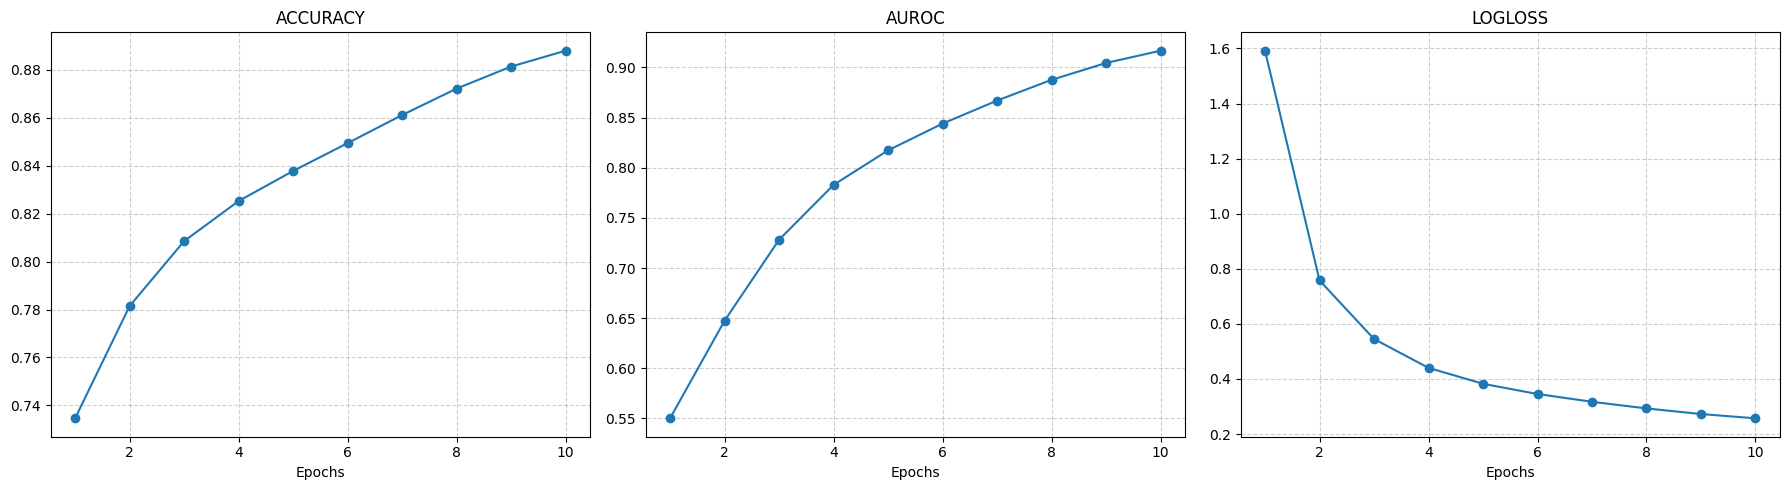

In [4]:
history = recommender.train(model, train_loader, optimizer, device, config["training"]["epochs"])
visualizer.plot_history(history)

Recommend (fm): 100%|████████████| 943/943 [00:13<00:00, 70.97it/s, user_id=942]


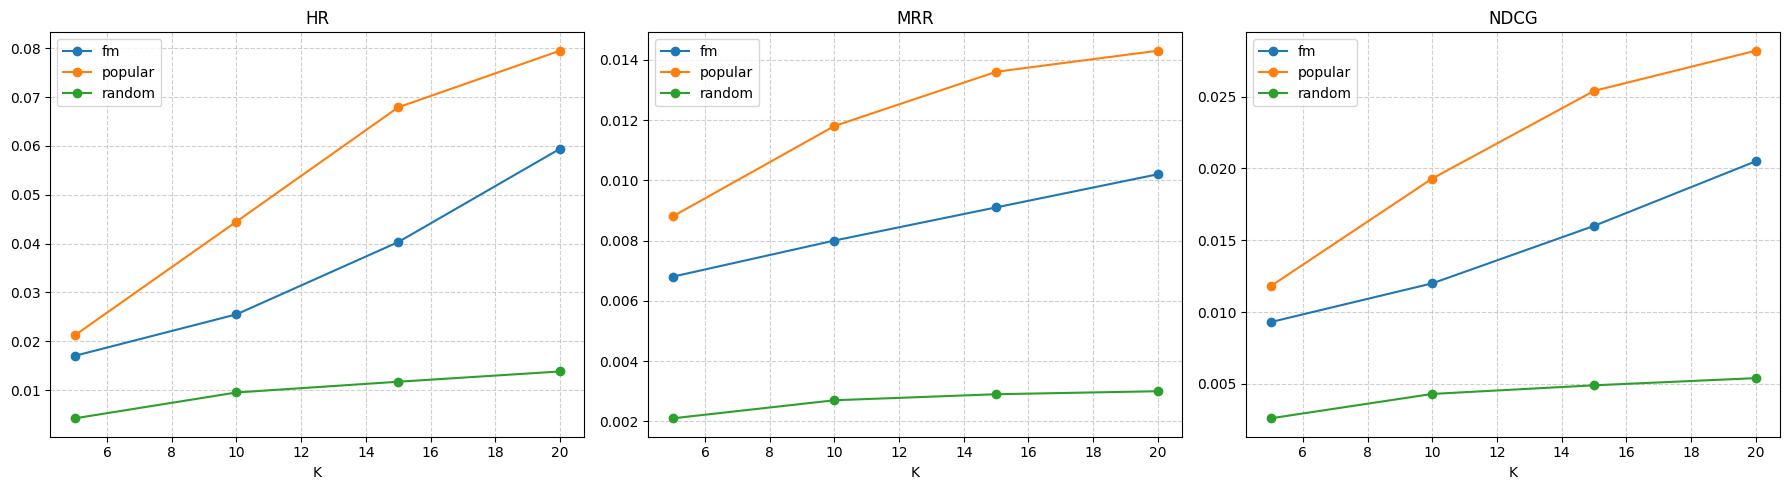

In [5]:
os.makedirs("results", exist_ok=True)
user_recommendations = recommender.inference(model, device, test_loader)
with open(f"results/{model.model_name}.json", "w") as f:
    json.dump({
        k: v.tolist() for k, v in user_recommendations.items()
    }, f)

ks = [5, 10, 15, 20]
_test = test[test["rating"]==1]
recommendations = {
    "popular": np.array(experiment_group["popular"]),
    "random": np.array(experiment_group["random"]),
    model.model_name: user_recommendations
}
results = evaluate(_test, recommendations, ks)
visualizer.plot_metrics(results)